In [58]:
from brainrender.atlas_specific import GeneExpressionAPI
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from tqdm import tqdm
import os
import pandas as pd
from os.path import join as pjoin
from tqdm import tqdm

import matplotlib
font = {"size": 20}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

%matplotlib widget

In [73]:
DATA_DIR = "/Users/andrewjones/Documents/beehive/spatial_stitching/spatial-alignment/data/mouse_brain_slideseq/pcp4_only/"
RAW_DATA_DIR = "/Users/andrewjones/Documents/beehive/spatial_stitching/spatial-alignment/data/mouse_brain_slideseq/12_allMTXs_CCF/"

In [74]:
fnames = os.listdir(DATA_DIR)
fnames = [f for f in fnames if f.endswith(".csv")]
slice_nums = np.array([int(f.split(".")[0].split("_")[-1]) for f in fnames])
slice_nums = slice_nums[np.argsort(slice_nums)]
len(fnames)

43

In [77]:
data = []

for ii, fname in enumerate(fnames):
    slice_num = int(fname.split(".")[0].split("_")[-1])
    curr_data = pd.read_csv(pjoin(DATA_DIR, fname), index_col=0)
    curr_data["slice_num"] = slice_num
    curr_data["slice_index"] = ii
    data.append(curr_data[["Pcp4", "CCF3D_x", "CCF3D_y", "CCF3D_z", "Original_x", "Original_y", "slice_num", "slice_index"]])

data = pd.concat(data, axis=0)

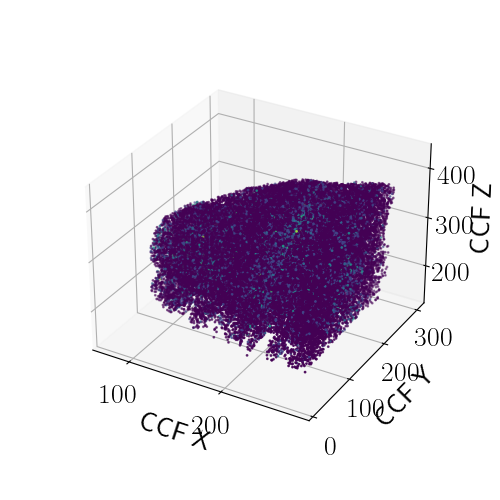

In [80]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

rand_idx = np.random.choice(np.arange(len(data)), size=50_000, replace=False)
ax.scatter3D(data.CCF3D_x.values[rand_idx], data.CCF3D_y.values[rand_idx], data.CCF3D_z.values[rand_idx], c=np.log(data.Pcp4.values[rand_idx] + 1), s=1)
# ax.scatter3D(data.Original_x.values[rand_idx], data.Original_y.values[rand_idx], data.slice_num.values[rand_idx], c=np.log(data.Pcp4.values[rand_idx] + 1), s=2)

ax.set_xlabel("CCF X", rotation=90)
ax.set_ylabel("CCF Y", rotation=90)
ax.set_zlabel("CCF Z", rotation=90)

plt.show()

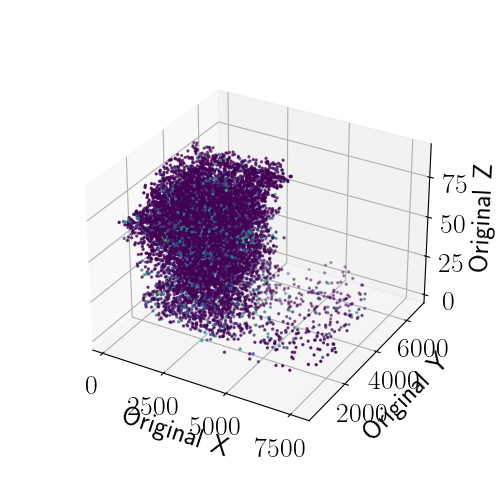

In [81]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

rand_idx = np.random.choice(np.arange(len(data)), size=10_000, replace=False)
# ax.scatter3D(data.CCF3D_x.values[rand_idx], data.CCF3D_y.values[rand_idx], data.CCF3D_z.values[rand_idx], c=np.log(data.Pcp4.values[rand_idx] + 1), s=1)
ax.scatter3D(data.Original_x.values[rand_idx], data.Original_y.values[rand_idx], data.slice_num.values[rand_idx], c=np.log(data.Pcp4.values[rand_idx] + 1), s=2)

ax.set_xlabel("Original X", rotation=90)
ax.set_ylabel("Original Y", rotation=90)
ax.set_zlabel("Original Z", rotation=90)

plt.show()

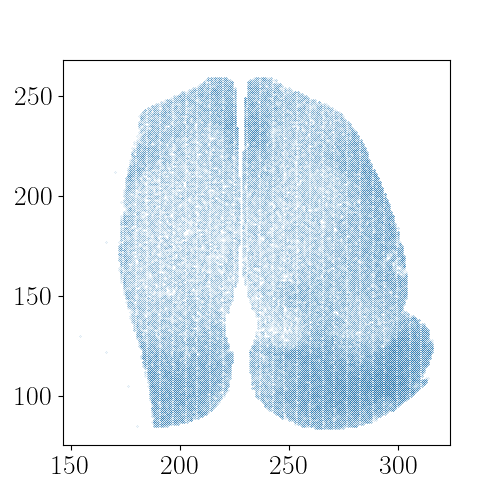

In [45]:
plt.close()
fig = plt.figure(figsize=(5, 5))

plt.scatter(data[data.slice_index == 1].CCF3D_z, data[data.slice_index == 1].CCF3D_y, s=.01)
# plt.scatter(X_slice1_ccf[:, 0], X_slice1_ccf[:, 1], s=.01)

# rand_idx = np.random.choice(np.arange(len(data[data.slice_num == 1])), size=10_000, replace=False)
# plt.scatter(data[data.slice_num == 1].CCF3D_z.values[rand_idx], 
#             data[data.slice_num == 1].CCF3D_y.values[rand_idx], 
#             c=np.log(data[data.slice_num == 1].Pcp4.values[rand_idx] + 1), 
#             s=1)


plt.show()

In [82]:
fnames = os.listdir(RAW_DATA_DIR)
mtx_fnames = np.array([x for x in fnames if x.endswith(".mtx.gz")])
slice_nums = np.sort(np.array([int(x.split("_")[1][1:]) for x in mtx_fnames]))

coords = []
coords_orig = []
for curr_slice_num in tqdm(slice_nums):
    
    # Load metadata
    metadata = pd.read_table(pjoin(RAW_DATA_DIR, "MBASS_d{}_metadata.tsv".format(str(curr_slice_num))))
    metadata = metadata[~metadata.isOutsideCCF]
    metadata["Original_z"] = curr_slice_num
    
    curr_coords = metadata[["CCF3D_x", "CCF3D_y", "CCF3D_z"]].values
    coords.append(curr_coords)
    
    curr_coords = metadata[["Original_x", "Original_y", "Original_z"]].values
    coords_orig.append(curr_coords)

100%|██████████| 101/101 [00:43<00:00,  2.34it/s]


In [83]:
all_coords = np.concatenate(coords, axis=0)
all_coords_orig = np.concatenate(coords_orig, axis=0)
all_coords.shape, all_coords_orig.shape

((11967926, 3), (11967926, 3))

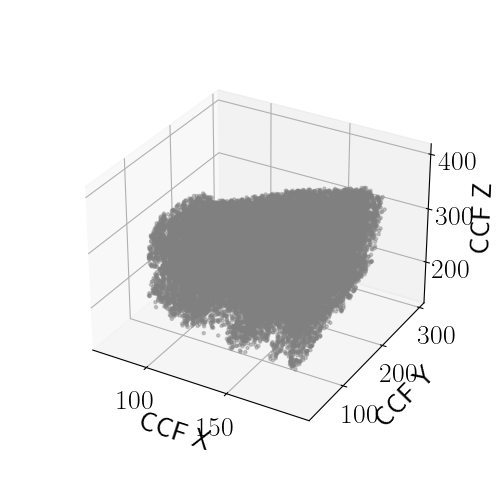

In [72]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

rand_idx = np.random.choice(np.arange(len(data)), size=30_000, replace=False)
ax.scatter3D(all_coords[rand_idx, 0], all_coords[rand_idx, 1], all_coords[rand_idx, 2], s=5, c="gray", alpha=0.4)

ax.set_xlabel("CCF X", rotation=90)
ax.set_ylabel("CCF Y", rotation=90)
ax.set_zlabel("CCF Z", rotation=90)

plt.show()

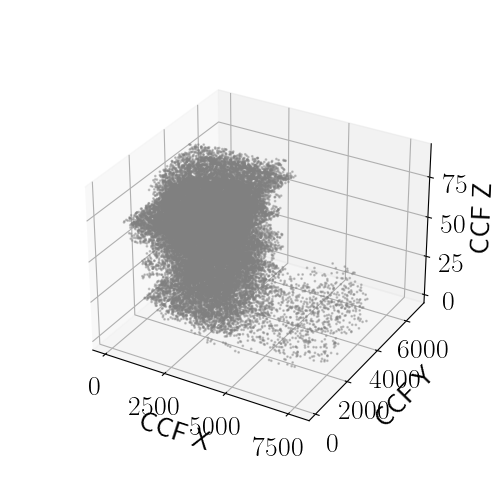

In [87]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

rand_idx = np.random.choice(np.arange(len(data)), size=30_000, replace=False)
ax.scatter3D(all_coords_orig[rand_idx, 0], all_coords_orig[rand_idx, 1], all_coords_orig[rand_idx, 2], s=1, c="gray", alpha=0.4)

ax.set_xlabel("CCF X", rotation=90)
ax.set_ylabel("CCF Y", rotation=90)
ax.set_zlabel("CCF Z", rotation=90)

plt.show()

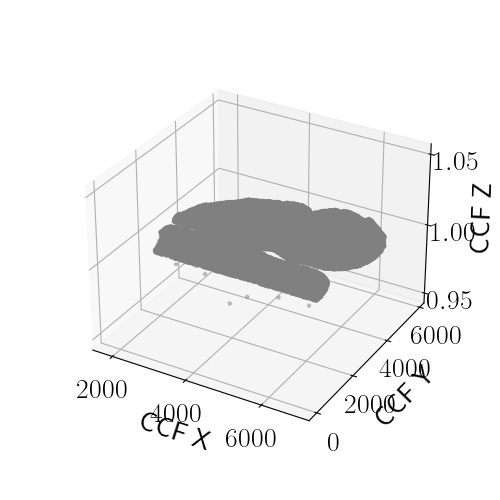

In [86]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

rand_idx = np.random.choice(np.arange(len(data)), size=30_000, replace=False)
# ax.scatter3D(all_coords_orig[rand_idx, 0], all_coords_orig[rand_idx, 1], all_coords_orig[rand_idx, 2], s=5, c="gray", alpha=0.4)
ax.scatter3D(all_coords_orig[all_coords_orig[:, 2] == 1][:, 0], all_coords_orig[all_coords_orig[:, 2] == 1][:, 1], all_coords_orig[all_coords_orig[:, 2] == 1][:, 2], s=5, c="gray", alpha=0.4)


ax.set_xlabel("CCF X", rotation=90)
ax.set_ylabel("CCF Y", rotation=90)
ax.set_zlabel("CCF Z", rotation=90)

plt.show()